In [1392]:
import numpy as np  # type: ignore
import matplotlib.pyplot as plt  # type: ignore
import pandas as pd  # type: ignore
import math as m
import random

In [1393]:
NUM_ITERATIONS = 10
NUM_WOLFS = 10

In [1394]:
NUM_INTERVALS = 96

In [1395]:
# Matriz de carros: 1-Modelo | 2-Capacidade (kM) | 3-ID | 4-disponibilidade | 5-viagem | 6-Capacidade | 7-Capacidade da bateria (kWh) | 8-Taxa de carga da bateria (kW) | 9-Taxa de descarga da bateria (kW)
cars_array = np.array(
    [
        [1, 170, 1, 0, 0, 4, 44.9, 0.2 * 44.9, -50 / 4, (60 / 170) * 44.9 * 0.25],
        [2, 230, 2, 0, 0, 5, 229, 0.2 * 229, -100 / 4, (60 / 230) * 229 * 0.25],
        [3, 230, 3, 0, 0, 3, 174, 0.2 * 174, -100 / 4, (60 / 230) * 174 * 0.25],
    ]
)
df = pd.DataFrame(
    cars_array,
    columns=[
        "Modelo",
        "Capacidade (km)",
        "ID",
        "Disponibilidade",
        "Viagem",
        "Capacidade",
        "Capacidade da bateria (kWh)",
        "Taxa de carga da bateria (kW)",
        "Taxa de descarga da bateria (kW)",
        "Taxa de carga específica (kW)",
    ],
)

df.head()

,Modelo,Capacidade (km),ID,Disponibilidade,Viagem,Capacidade,Capacidade da bateria (kWh),Taxa de carga da bateria (kW),Taxa de descarga da bateria (kW),Taxa de carga específica (kW)
0,1.0,170.0,1.0,0.0,0.0,4.0,44.9,8.98,-12.5,3.961765
1,2.0,230.0,2.0,0.0,0.0,5.0,229.0,45.80,-25.0,14.934783
2,3.0,230.0,3.0,0.0,0.0,3.0,174.0,34.80,-25.0,11.347826


In [1396]:
cars = [
    {
        "autonomy_km": car[1],
        "autonomy_kwh": car[6],
        "tx_charge": np.abs((car[7] / 60) * 15),
        "tx_discharge": np.abs((car[8] / 60) * 15),
    }
    for car in cars_array
]

In [1397]:
for car in cars:
    print(car)

{'autonomy_km': np.float64(170.0), 'autonomy_kwh': np.float64(44.9), 'tx_charge': np.float64(2.245), 'tx_discharge': np.float64(3.125)}
{'autonomy_km': np.float64(230.0), 'autonomy_kwh': np.float64(229.0), 'tx_charge': np.float64(11.450000000000001), 'tx_discharge': np.float64(6.25)}
{'autonomy_km': np.float64(230.0), 'autonomy_kwh': np.float64(174.0), 'tx_charge': np.float64(8.700000000000001), 'tx_discharge': np.float64(6.25)}


In [1398]:
travels = [
    [(15, 20), (48, 55), (90, 92)],
    [(17, 24), (90, 92)],
    [(50, 55), (76, 89)],
]

In [1399]:
def find_available_intervals(occupied_positions):
    available_intervals = []
    current_start = 0

    for start, end in sorted(occupied_positions):
        if current_start < start:
            available_intervals.append((current_start, start - 1))
        current_start = end + 1

    if current_start < NUM_INTERVALS:
        available_intervals.append((current_start, NUM_INTERVALS - 1))

    return available_intervals

In [1400]:
available_intervals = [find_available_intervals(travel) for travel in travels]
available_intervals

[[(0, 14), (21, 47), (56, 89), (93, 95)],
 [(0, 16), (25, 89), (93, 95)],
 [(0, 49), (56, 75), (90, 95)]]

In [1401]:
def calculate_travel_charge_time(travel, tx_charge, tx_discharge):
    start, end = travel
    spent_energy = (end - start + 1) * tx_discharge
    charge_time = m.ceil(spent_energy / tx_charge)

    return charge_time

In [1402]:
charge_times = [
    [
        calculate_travel_charge_time(travel, car["tx_charge"], car["tx_discharge"])
        for travel in car_travels
    ]
    + [0] * (len(available_interval) - len(car_travels))
    for car, car_travels, available_interval in zip(
        cars.copy(), travels.copy(), available_intervals.copy()
    )
]
charge_times

[[9, 12, 5, 0], [5, 2, 0], [5, 11, 0]]

In [1403]:
def generate_min_charging_random_vector(total_size, min_charging, car):
    vector = []
    car_battery = 0
    is_charged = False

    for i in range(total_size):
        if i == 0:
            choice = 1
        elif car_battery - car["tx_discharge"] >= 0 and not is_charged:
            choice = random.choice([-1, 1])
        elif car_battery - car["tx_discharge"] >= 0:
            choice = -1
        elif not is_charged:
            choice = 1

        vector_aux = vector.copy()
        vector_aux.append(choice)
        vector_aux.append((total_size - i - 1) * [1])
        chargings = vector_aux.count(1)
        dischargings = vector_aux.count(-1)

        if (
            chargings * car["tx_charge"] - dischargings * car["tx_discharge"]
            < min_charging * car["tx_charge"]
        ):
            choice = 1

        if choice == -1:
            car_battery -= car["tx_discharge"]
            is_charged = False
        else:
            car_battery += car["tx_charge"]

        if car_battery >= car["autonomy_kwh"]:
            car_battery = car["autonomy_kwh"]
            is_charged = True

        vector.append(choice)

    return vector

In [1404]:
cars_state = [
    element
    for available_list in [
        generate_min_charging_random_vector(end - start + 1, min_charge, car)
        for charge_time, car_available_intervals, car in zip(
            charge_times, available_intervals, cars
        )
        for (start, end), min_charge in zip(car_available_intervals, charge_time)
    ]
    for element in available_list
]

print(cars_state)
print(len(cars_state))

15 9 {'autonomy_km': np.float64(170.0), 'autonomy_kwh': np.float64(44.9), 'tx_charge': np.float64(2.245), 'tx_discharge': np.float64(3.125)}
27 12 {'autonomy_km': np.float64(170.0), 'autonomy_kwh': np.float64(44.9), 'tx_charge': np.float64(2.245), 'tx_discharge': np.float64(3.125)}
34 5 {'autonomy_km': np.float64(170.0), 'autonomy_kwh': np.float64(44.9), 'tx_charge': np.float64(2.245), 'tx_discharge': np.float64(3.125)}
3 0 {'autonomy_km': np.float64(170.0), 'autonomy_kwh': np.float64(44.9), 'tx_charge': np.float64(2.245), 'tx_discharge': np.float64(3.125)}
17 5 {'autonomy_km': np.float64(230.0), 'autonomy_kwh': np.float64(229.0), 'tx_charge': np.float64(11.450000000000001), 'tx_discharge': np.float64(6.25)}
65 2 {'autonomy_km': np.float64(230.0), 'autonomy_kwh': np.float64(229.0), 'tx_charge': np.float64(11.450000000000001), 'tx_discharge': np.float64(6.25)}
3 0 {'autonomy_km': np.float64(230.0), 'autonomy_kwh': np.float64(229.0), 'tx_charge': np.float64(11.450000000000001), 'tx_disch

In [1405]:
for i, car_travels in enumerate(travels):
    for travel in car_travels:
        start, end = travel
        position = start + 96 * i
        cars_state[position:position] = [0] * (end - start + 1)

print(*cars_state)
print(len(cars_state))

1 1 1 1 1 1 1 1 1 1 1 1 1 -1 -1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 -1 1 -1 1 1 1 -1 -1 1 -1 1 1 -1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 -1 1 -1 1 1 -1 1 1 1 1 -1 1 -1 1 1 -1 1 1 -1 1 1 -1 1 -1 1 1 -1 0 0 0 1 1 -1 1 1 1 1 1 1 -1 1 1 -1 1 1 -1 1 -1 1 -1 0 0 0 0 0 0 0 0 1 1 1 -1 1 1 1 1 -1 1 1 -1 1 -1 1 1 -1 -1 -1 -1 -1 1 1 -1 1 1 -1 1 1 1 1 1 -1 1 -1 1 -1 1 1 -1 1 -1 1 1 1 -1 1 -1 -1 -1 -1 -1 1 1 -1 1 -1 1 -1 1 -1 -1 1 1 -1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 -1 1 -1 -1 1 1 -1 -1 -1 -1 1 -1 1 -1 -1 1 -1 -1 -1 1 -1 1 -1 -1 1 1 -1 1 -1 1 -1 1 1 1 -1 1 1 1 -1 -1 -1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 -1 -1 1 -1 -1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 -1 1 1 1 -1
288


In [1406]:
def split_list(lst, chunk_size=NUM_INTERVALS):
    return [lst[i : i + chunk_size] for i in range(0, len(lst), chunk_size)]

In [1407]:
separated_cars_state = split_list(cars_state)

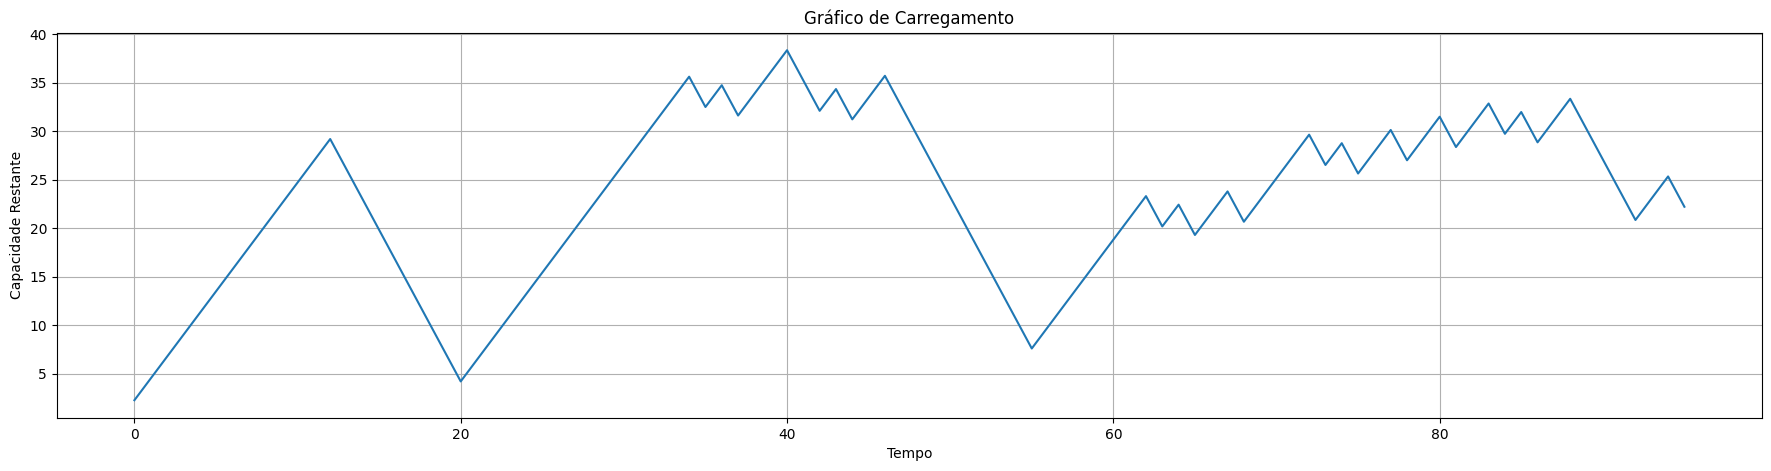

In [1408]:
car_energy = 0

capacity_in_time = []

for car_state in separated_cars_state[0]:
    if car_state <= 0:
        car_energy -= cars[0]["tx_discharge"]
    else:
        car_energy = min(car_energy + cars[0]["tx_charge"], cars[0]["autonomy_kwh"])

    capacity_in_time.append(car_energy)


# Plotar o gráfico
plt.figure(figsize=(22, 5))
plt.plot(capacity_in_time)
plt.title("Gráfico de Carregamento")
plt.xlabel("Tempo")
plt.ylabel("Capacidade Restante")
plt.grid(True)
plt.show()

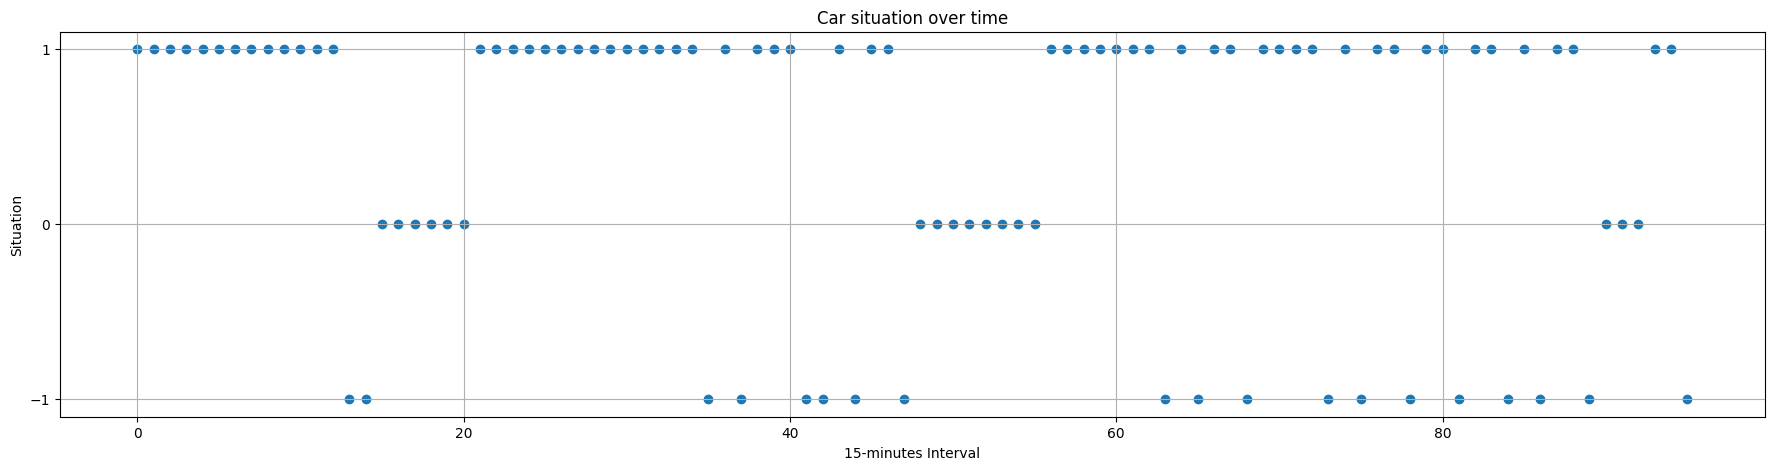

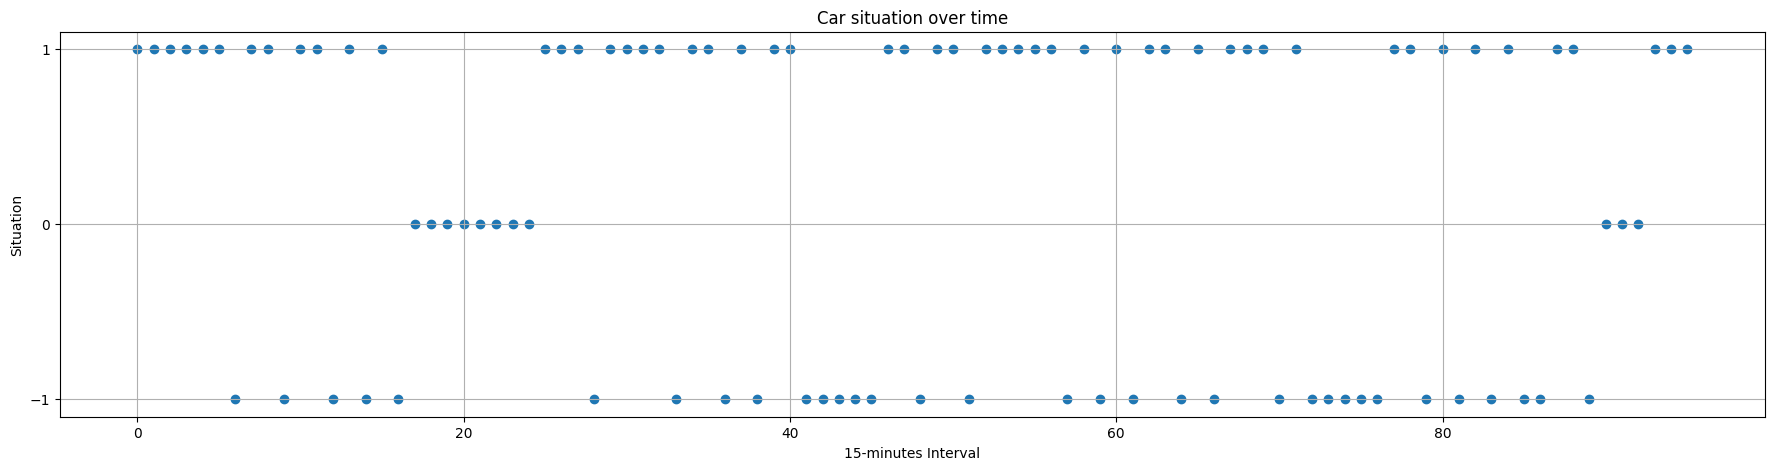

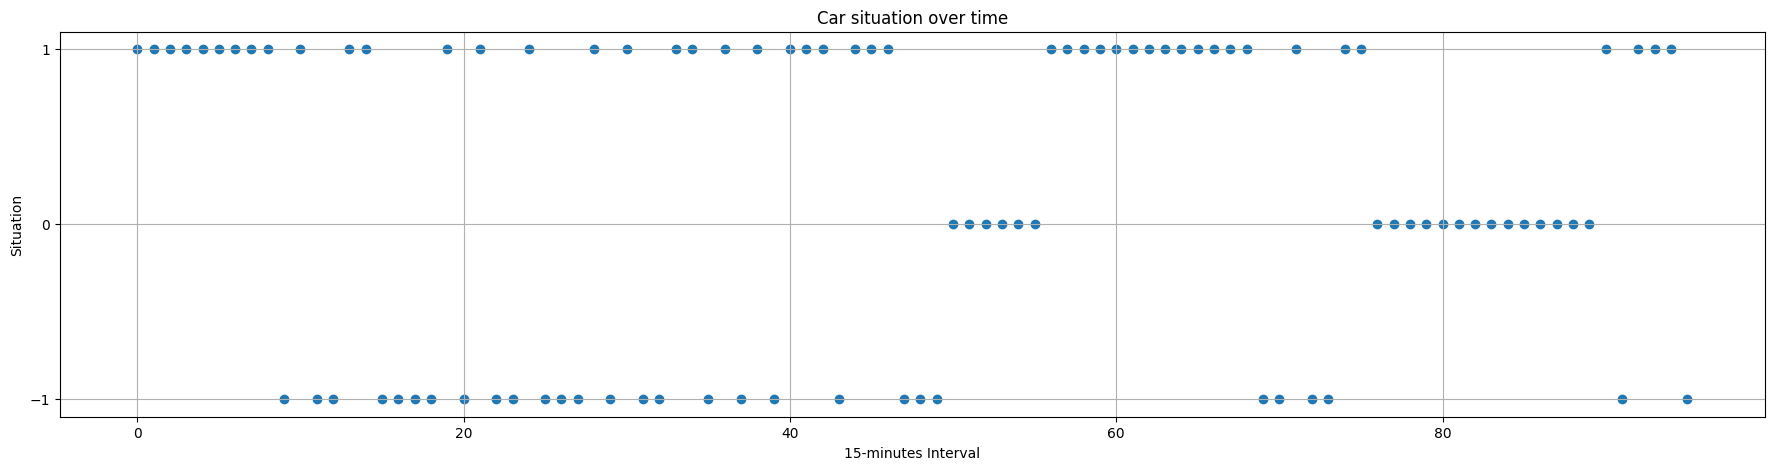

In [1409]:
for item in separated_cars_state:
    plt.figure(figsize=(22, 5))
    plt.scatter(range(len(item)), item, marker="o")
    plt.title("Car situation over time")
    plt.xlabel("15-minutes Interval")
    plt.ylabel("Situation")
    plt.grid(True)
    plt.yticks([-1, 0, 1])
    plt.ylim(-1.1, 1.1)
    plt.show()